In [1]:
from __future__ import division, print_function, absolute_import, unicode_literals
import numpy as np
import astropy.io.fits as fits
import astropy.coordinates as coords
import astropy.units as u
from astropy.time import Time
import astropy.utils
from glob import glob
import matplotlib.pyplot as plt
import shelve, pickle
import time
%matplotlib inline

#Hands-On Exercise 2:
Making a Lightcurve from PTF catalog data
========

#####Version 0.2

This "hands-on" session will proceed differently from those that are going to follow. Below, we have included all of the code that is necessary to create light curves from PTF SExtractor catalogs. (For additional information on [SExtractor](http://www.astromatic.net/software/sextractor) please consult the [SExtractor manual](https://www.astromatic.net/pubsvn/software/sextractor/trunk/doc/sextractor.pdf). This manual is far from complete, however, so you may want to also consult [SExtractor For Dummies](http://mensa.ast.uct.ac.za/~holwerda/SE/Manual_files/Guide2source_extractor_1.pdf).) You will not need to write any software, but we will still go through everything step by step so you can see the details of how the light curves are constructed. 

As we saw in the previous talk, there are many different ways to make photometric measurements, which are necessary to ultimately create a light curve. In brief, the procedure below matches sources across epochs (i.e. different observations) by comparing everything to a deep reference catalog. Photometric corrections (i.e. differential photometry) are then calculated based on how much the *aperture* photometry on each epoch differs from the reference image. 

This notebook will include commands necessary to load and manipulate PTF data, as well as a procedure that is needed to make differential corrections to the light curves. 

***
By EC Bellm and AA Miller (c) 2015 Aug 05

##Problem 1) Load Source Information from the Reference Catalog

Our first step is create a "master" source list based on the reference catalog. We adopt the reference image for this purpose for two reasons: most importantly, (i) PTF reference images are made from stacks of the individual exposures so they are typically significantly deeper than individual exposures, and (ii) the reference images cover a larger footprint than the individual exposures.

First, we provide the path to the reference catalog and store it in `reference_catalog`. 

In [2]:
reference_catalog = '../data/PTF_Refims_Files/PTF_d022683_f02_c06_u000114210_p12_sexcat.ctlg'
# select R-band data (f02)

There is a lot of information for each source, and the overall image, in each of these catalog files. As a demonstration of the parameters available for each source, we will next load the file and show each of the parameters. *Note - for a detailed explanation for the definition of each of these columns, please refer to the `SExtractor` documentation links above.*

In [3]:
hdus = fits.open(reference_catalog)
data = hdus[1].data
data.columns

ColDefs(
    name = 'NUMBER'; format = '1J'; disp = 'I10'
    name = 'FLAGS'; format = '1I'; disp = 'I3'
    name = 'XWIN_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F10.3'
    name = 'YWIN_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F10.3'
    name = 'X_WORLD'; format = '1D'; unit = 'deg'; disp = 'E15.10'
    name = 'Y_WORLD'; format = '1D'; unit = 'deg'; disp = 'E15.10'
    name = 'XPEAK_IMAGE'; format = '1J'; unit = 'pixel'; disp = 'I10'
    name = 'YPEAK_IMAGE'; format = '1J'; unit = 'pixel'; disp = 'I10'
    name = 'ERRTHETAWIN_IMAGE'; format = '1E'; unit = 'deg'; disp = 'F5.1'
    name = 'DELTAWIN_J2000'; format = '1D'; unit = 'deg'; disp = 'F11.7'
    name = 'X2WIN_IMAGE'; format = '1D'; unit = 'pixel**2'; disp = 'E15.10'
    name = 'Y2WIN_IMAGE'; format = '1D'; unit = 'pixel**2'; disp = 'E15.10'
    name = 'XYWIN_IMAGE'; format = '1D'; unit = 'pixel**2'; disp = 'E15.10'
    name = 'AWIN_WORLD'; format = '1E'; unit = 'deg'; disp = 'G12.7'
    name = 'BWIN_WORLD'; format = 

In the next step, we define a function that will read the catalog. The main `SExtractor` parameters that we will need are: `MAG_AUTO` and `MAGERR_AUTO`, the mag and mag uncertainty, respectively, as well as `X_WORLD` and `Y_WORLD`, which are the RA and Dec, respectively, and finally `flags`, which contains processing flags. After reading the catalog, the function will select sources that have no flags, and return the position of these sources, their brightness, as well as a `SExtractor` parameter `CLASS_STAR`, which provides a numerical estimation of whether or not a source is a star. Sources with `CLASS_STAR` $\sim 1$ are likely stars, and sources with `CLASS_STAR` $\sim 0$ are likely galaxies, but beware that this classification is far from perfect, especially at the faint end. *Recall that galaxies cannot be used for differential photometry as they are resolved.* 

In [4]:
def load_ref_catalog(reference_catalog):
    hdus = fits.open(reference_catalog)
    data = hdus[1].data
    # filter flagged detections
    w = ((data['flags'] & 506 == 0) & (data['MAG_AUTO'] < 99))
    data = data[w]

    ref_coords = coords.SkyCoord(data['X_WORLD'], data['Y_WORLD'],frame='icrs',unit='deg')

    star_class = np.array(data["CLASS_STAR"]).T
    
    return np.vstack([data['MAG_AUTO'],data['MAGERR_AUTO']]).T, ref_coords, star_class

Now, we can run the function, and determine the number of sources in our reference catalog. 

Following that, we will use the Python function `glob` to grab all of the individual SExtractor catalogs. These files contain the epoch by epoch photometric measurements of the sources in `ptfField` 22683 `ccd` 06. The file names will be stored as `epoch_catalogs`.

In [5]:
ref_mags, ref_coords, star_class = load_ref_catalog(reference_catalog)

epoch_catalogs = glob('../data/PTF_Procim_Files/PTF*f02*.ctlg.gz') # Note - files have been gzipped to save space

print("There are {:d} sources in the reference image".format( len(ref_mags) ))
print("...")
print("There are {:d} epochs for this field".format( len(epoch_catalogs) ))

There are 14042 sources in the reference image
...
There are 72 epochs for this field


##Problem 2) Match Individual Detections to Reference Catalog Sources

The next step towards constructing light curves is one of the most difficult: source association. From the reference catalog, we know the positions of the stars and the galaxies in `ptfField` 22683 `ccd` 06. The positions of these stars and galaxies as measured on the individual epochs will be different than the positions measured on the reference image, so we need to decide how to associate the two. 

Simply put, we will crossmatch the reference catalog and individual epoch catalogs, and consider all associations with a separation less than our *tolerance* to be a match. For the most part, this is the standard procedure for source association, and we will adopt a *tolerance* of 1.5 arcsec (the most common value is 1 arcsec). 

We will use `astropy` to crossmatch sources between the two catalogs, and we will perform a loop over every catalog so we can build up lightcurves for the individual sources. To store the data, we will construct a two-dimenstional `NumPy` mask array. Each row in the array will represent a source in the reference catalog, while each column will represent each epoch. Thus, each source's light curve can be read by examining the corresponding row of the `mags` array. We will also store the uncertainty of each mag measurement in `magerrs`. The date corresponding to each column will be stored in a separate 1D array: `mjds`. Finally, including the masks allows us to track when a source is not detected in an individual exposure. 

*Note - there are some downsides to this approach*: (i) crossmatching to sources in the reference catalog means we will miss any transients in this field as they are (presumably) not in the reference image. (ii) The matching tolerance of 1.5 arcsec is informed [0.01 arcsec is way too small and 100 arcsec is way too big], but arbitrary. Is a source separation of 1.49 arcsec much more significant than a source separation of 1.51 arcsec? While it is more significant, a binary decision threshold at 1.5 is far from perfect. (iii) This procedure assumes that the astrometric information for each catalog is correct. While this is true for the vast, vast majority of PTF images, there are some fields ($< 1\%$) where the astrometric solution can be incorrect by more than a few arcsec.

In [6]:
def crossmatch_epochs(reference_coords, epoch_catalogs):
    
    n_stars = len(reference_coords)
    n_epochs = len(epoch_catalogs)
    
    mags = np.ma.zeros([n_stars, n_epochs])
    magerrs = np.ma.zeros([n_stars, n_epochs])
    mjds = np.ma.zeros(n_epochs)
    
    with astropy.utils.console.ProgressBar(len(epoch_catalogs),ipython_widget=True) as bar:
        for i, catalog in enumerate(epoch_catalogs):
            hdus = fits.open(catalog)
            data = hdus[1].data
            hdr = hdus[2].header
            # filter flagged detections
            w = ((data['flags'] & 506 == 0) & (data['imaflags_iso'] & 1821 == 0))
            data = data[w]

            epoch_coords = coords.SkyCoord(data['X_WORLD'], data['Y_WORLD'],frame='icrs',unit='deg')
            idx, sep, dist = coords.match_coordinates_sky(epoch_coords, reference_coords)
        
            wmatch = (sep <= 1.5*u.arcsec)
        
        # store data
            if np.sum(wmatch):
                mags[idx[wmatch],i] = data[wmatch]['MAG_APER'][:,2] + data[wmatch]['ZEROPOINT']
                magerrs[idx[wmatch],i] = data[wmatch]['MAGERR_APER'][:,2]
                mjds[i] = hdr['OBSMJD']

            bar.update()
    return mjds, mags, magerrs

With the function defined, we now populate and store the arrays with the light curve information.

In [7]:
mjds,mags,magerrs = crossmatch_epochs(ref_coords, epoch_catalogs)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


At times, SExtrator will produce "measurements" that are clearly non-physical, such as magnitude measurements of 99 (while a source may be that faint, we cannot detect such a source with PTF). We will mask everything with a clearly wrong magnitude measurement.

In [8]:
# mask obviously bad mags
wbad = (mags < 10) | (mags > 25)
mags[wbad] = np.ma.masked
magerrs[wbad] = np.ma.masked

Now that we have performed source assoiciation and populated the `mags` array, we can plot light curves of individual sources. Here is an example for the 63rd source in the array (recall that `NumPy` arrays are zero indexed). 

scatter = 0.108


/Users/adamamiller/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:4085: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


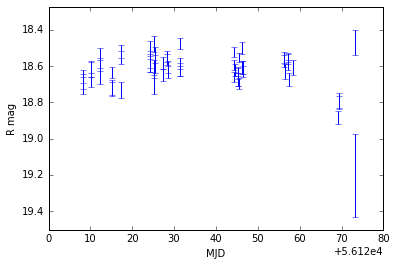

In [10]:
source_idx = 62
plt.errorbar(mjds, mags[source_idx,:],magerrs[source_idx,:],fmt='none')
plt.ylim(np.ma.max(mags[source_idx,:])+0.3, np.ma.min(mags[source_idx,:])-0.2)
plt.xlabel("MJD")
plt.ylabel("R mag")

print("scatter = {:.3f}".format(np.ma.std(mags[source_idx,:])))

Note that the scatter for this source is $\sim 0.11$ mag. We will later show this to be the case, but for now, trust us that this scatter is large for a source with average brightness $\sim 18.6$ mag. Either, this is a genuine variable star, with a significant decrease in brightness around MJD 56193, or, this procedure, so far, is *poor*. 

For reasons that will become clear later, we are now going to filter our arrays so that only sources with at least 20 detections included. As a brief justification - sources with zero detections should, obviously, be excluded from our array, while requiring 20 detections improves our ability to reliably measure periodicity.

Before we do this, we can examine which sources are most likely to be affected by this decision. For each source, we can plot the number of masked epochs (i.e. non-detections) as a function of that source's brightness.

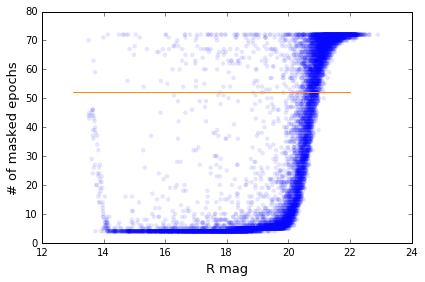

In [11]:
n_epochs = len(epoch_catalogs)

plt.scatter(ref_mags[:,0], np.ma.sum(mags.mask,axis=1), alpha=0.1, edgecolor = "None")
plt.plot([13, 22], [n_epochs - 20, n_epochs - 20], 'DarkOrange') # plot boundary for sources with Ndet > 20
plt.xlabel('R mag', fontsize = 13)
plt.ylabel('# of masked epochs', fontsize = 13)
plt.tight_layout()

From this plot a few things are immediately clear: (i) potentially saturated sources ($R \lesssim 14$ mag) are likely to have fewer detections (mostly because they are being flagged by `SExtractor`), (ii) faint sources ($R \gtrsim 20$ mag) are likely to have fewer detecions (because the limiting magnitude of individual PTF exposures is $\sim 20.5$ mag, and (iii) the faintest sources are the most likely to have light curves with very few points. 

Identifying sources with at least 20 epochs can be done using a conditional statement, and we will store the Boolean results of this conditional statement in an array `Ndet20`. We will use this array to remove sources with fewer than 20 detections in their light curves. 

In [12]:
Ndet20 = n_epochs - np.ma.sum(mags.mask,axis=1) >= 20

mags = mags[Ndet20]
magerrs = magerrs[Ndet20]

ref_mags = ref_mags[Ndet20]
ref_coords = ref_coords[Ndet20]
star_class = star_class[Ndet20]

print('There are {:d} sources with > 20 detections on individual epochs.'.format( sum(Ndet20) ))

There are 8546 sources with > 20 detections on individual epochs.


Now that we have eliminated the poorly sampled light curves, we can also if the typical uncertainties measured by SExtractor are properly estimated by comparing their values to the typical scatter in a given light curve. For non-variable stars the scatter should be approximately equal to the mean uncertainty measurement for a given star.

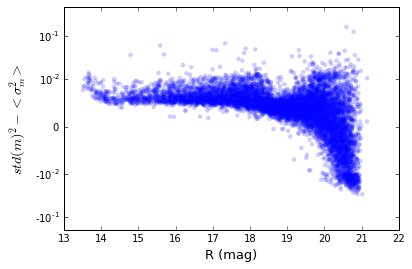

In [13]:
plt.scatter(ref_mags[:,0], np.ma.std(mags,axis=1)**2. - np.ma.mean(magerrs**2.,axis=1), 
            edgecolor = "None", alpha = 0.2)
plt.ylim(-0.2,0.5)
plt.yscale('symlog', linthreshy=0.01)
plt.xlabel('R (mag)', fontsize = 13)
plt.ylabel(r'$ std(m)^2 - <\sigma_m^2>$', fontsize = 14)

At the bright end, corresponding to sources brighter than 19th mag, we see that the typical scatter is larger than the mean uncertainty measurement. We can improve the scatter, however, so we will re-investigate this feature later. You will also notice that at the faint end the scatter is typically smaller than the mean uncertainty. This occurs because the light curves produced by our methodology are biased - in particular, the faint sources are more likely to be detected in epochs where they are a little brighter than normal and less likely to be detected in epochs where they are a little fainter than normal. As a result, summary statistics for these sources (essentially everything fainter than 20th mag if you scroll up two plots), will be misleading. 

We can also plot the typical scatter as a function of magnitude. This diagnostic for the photometric performance of a time-domain survey is the most common plot that you'll find in the literature. 

*Note - (1) here we take standard deviation of a log quantity, mag. This will overestimate the true value of the scatter at lowish S/N. It’s always best to compute stats in flux space then convert to mag. For simplicity we skip that here. Further examples of the dangers of statistical inference from mag measures can be found on [Frank Masci's website](http://web.ipac.caltech.edu/staff/fmasci/home/mystats/logfluxbias.html).(2) Non-detections on the faint end artificially supress the overall scatter.*

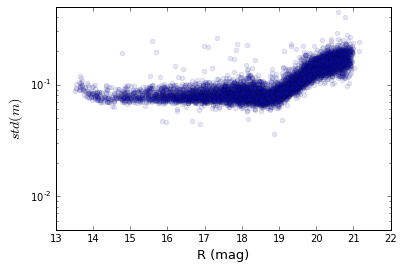

In [14]:
# examine a plot of the typical scatter as a function of magnitude

plt.scatter(ref_mags[:,0], np.ma.std(mags,axis=1),alpha=0.1)
plt.ylim(0.005,0.5)
plt.yscale("log")
plt.xlabel('R (mag)', fontsize = 13)
plt.ylabel(r'$std(m)$', fontsize = 14)

This plot shows that for a typical star ($R < 19$ mag), we can achieve a scatter of $\sim 0.08$ mag. As has already been noted - this performance is poor for stars this bright with a telescope as large as P48. 

##Problem 3) Calculate Differential Photometry Corrections

*Why is the scatter so large for PTF light curves?*

There are two reasons this is the case:

1. We are measuring the scatter from fixed aperture measurements, but we have not accounted for the fact that the seeing varies image to image. We can correct for this via differential photometry, however. 
    
2. The calibration of PTF images only works properly on nights with photometric conditions (see Ofek et al. 2012). Again, we can correct for this via differential photometry.  

The basic idea for differential photometry is the following: using "standard" stars (what constitutes standard can be argued, but most importantly these should not be variable), small corrections to the photometry of every star in a given image are calculated in order to place the photometry from every epoch on the same relative zero-point. The corrections are determined by comparing the the "standard" stars to their mean (or median) value. Typically, the corrections are determined by averaging over a large number of stars. 

The function `relative_photometry`, which is defined below, goes through this procedure to improve the quality of the PTF light curves. To calculate the $\Delta m$ required for each epoch, we take a few (essentially justified) short cuts: only stars with $R \ge 14.5$ mag are included to avoid saturation, further stars with $R > 17$ mag are excluded so only high SNR sources are used to calculate the corrections, sources with the `SExtractor` parameter `CLASS_STAR` $< 0.9$ (i.e. likely galaxies) are excluded, and sources with `excess_variance` $> 0.1$ (defined below) are excluded to remove likely variable stars. After these exclusions, the remaining stars are used to calculate the median difference between their reference magnitude and their brightness on the individual epochs. 

In [15]:
def relative_photometry(ref_mags, star_class, mags, magerrs):
    #make copies, as we're going to modify the masks
    all_mags = mags.copy()
    all_errs = magerrs.copy()
    
    # average over observations
    refmags = np.ma.array(ref_mags[:,0])
    madmags = 1.48*np.ma.median(np.abs(all_mags - np.ma.median(all_mags, axis = 1).reshape(len(ref_mags),1)), axis = 1)
    MSE = np.ma.mean(all_errs**2.,axis=1)

    # exclude bad stars: highly variable, saturated, or faint
    # use excess variance to find bad objects
    excess_variance = madmags**2. - MSE
    wbad = np.where((np.abs(excess_variance) > 0.1) | (refmags < 14.5) | (refmags > 17) | (star_class < 0.9))
    # mask them out
    refmags[wbad] = np.ma.masked
    
    # exclude stars that are not detected in a majority of epochs
    Nepochs = len(all_mags[0,:])
    nbad = np.where(np.ma.sum(all_mags > 1, axis = 1) <= Nepochs/2.)
    refmags[nbad] = np.ma.masked

    # for each observation, take the median of the difference between the median mag and the observed mag
    # annoying dimension swapping to get the 1D vector to blow up right
    relative_zp = np.ma.median(all_mags - refmags.reshape((len(all_mags),1)),axis=0)

    return relative_zp

We can now use the `relative_photometry` function to calculate the $\Delta m$ for each epoch.

In [16]:
# compute the relative photometry and subtract it. Don't fret about error propagation
rel_zp = relative_photometry(ref_mags, star_class, mags, magerrs)
mags -= np.ma.resize(rel_zp, mags.shape)

To quickly see the effect of applying the $\Delta m$ corrections, we can once again plot the light curve of the source that we previously examined. 

scatter = 0.052


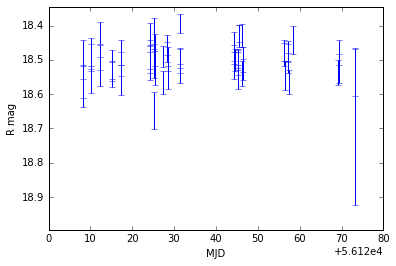

In [17]:
source_idx = 18
plt.errorbar(mjds, mags[source_idx,:],magerrs[source_idx,:],fmt='none')
plt.ylim(np.max(mags[source_idx,:])+0.3, np.min(mags[source_idx,:])-0.05)
plt.xlabel("MJD")
plt.ylabel("R mag")

print("scatter = {:.3f}".format(np.ma.std(mags[source_idx,:])))

Wow! It is now pretty clear that this source isn't a variable. The variations appear more or less consistent with Gaussian noise, and the scatter for this source has decreased by a factor of $\sim 2$. That is a significant improvement over what we obtained when using the "raw" values from the PTF `SExtractor` catalogs. 

Once again, the scatter as a function of magnitude will provide a decent proxy for the overall quality of the light curves.

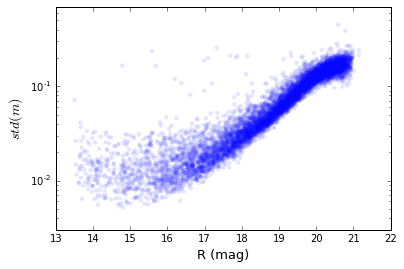

In [18]:
plt.scatter(ref_mags[:,0], np.ma.std(mags,axis=1),alpha=0.1, edgecolor = "None")
plt.ylim(0.003,0.7)
plt.yscale("log")
plt.xlim(13,22)
plt.xlabel('R (mag)', fontsize = 13)
plt.ylabel(r'$std(m)$', fontsize = 14)

This looks much, much better than what we had before, where all the bright stars had a scatter of $\sim 0.08$ mag. Now, the brightest stars have a scatter as small as $\sim 0.007$ mag, while even stars as faint as $R = 19$ mag have scatter $< 0.01$ mag. In other words, we now have good quality light curves (good enough for publication in many cases, though caution should always always always be applied to large survey data). 

##Problem 4) Store, and Later Access, the Light Curves

As we now have high quality light curves, it is important that we store the results of our work. We will do that using the `shelve` module within `Python` which will allow us to quickly and easily access each of these light curves in the future.  

In [ ]:
# save the output: ref_coords, mjds, mags, magerrs.

outfile = reference_catalog.split('/')[-1].replace('ctlg','shlv')
shelf = shelve.open('../data/'+outfile,flag='c',protocol=pickle.HIGHEST_PROTOCOL)
shelf['mjds'] = mjds
shelf['mags'] = mags
shelf['magerrs'] = magerrs
shelf['ref_coords'] = ref_coords
shelf.close()

Loading the shelf file is fast and easy.

In [ ]:
# demonstrate getting the data back out
shelf = shelve.open('../data/'+outfile)
for key in shelf.keys():
    print(key, shelf[key].shape)
shelf.close()

Finally, we have created a function, which we will use during the next few days, to produce the light curve for a source at a given RA and Dec on `ptfField` 22683 `ccd` 06. The function is below, and it loads the shelf file, performs a cross match against the user-supplied RA and Dec, and returns the light curve if there is a source with a separation less than 1 arcsec from the user-supplied position.

In [ ]:
def source_lightcurve(rel_phot_shlv, ra, dec, matchr = 1.0):
    """Crossmatch ra and dec to a PTF shelve file, to return light curve of a given star"""
    shelf = shelve.open(rel_phot_shlv)
    
    ref_coords = coords.SkyCoord(shelf["ref_coords"].ra, shelf["ref_coords"].dec,frame='icrs',unit='deg')    
    
    source_coords = coords.SkyCoord(ra, dec,frame='icrs',unit='deg')
    idx, sep, dist = coords.match_coordinates_sky(source_coords, ref_coords)        
    
    wmatch = (sep <= matchr*u.arcsec)
    
    if sum(wmatch) == 1:
        mjds = shelf["mjds"]
        mags = shelf["mags"][idx]
        magerrs = shelf["magerrs"][idx]
        
        # filter so we only return good points
        wgood = (mags.mask == False)

        if (np.sum(wgood) == 0):
            raise ValueError("No good photometry at this position.")

        return mjds[wgood], mags[wgood], magerrs[wgood]

    else:
        raise ValueError("There are no matches to the provided coordinates within %.1f arcsec" % (matchr))


**Problem 1** Test the `source_lightcurve` function - load the light curve for the star located at $\alpha_{\mathrm J2000} =$ 20:50:00.91, $\delta_{\mathrm J2000} =$ -00:42:23.8. An image of this star can be found [here](http://skyserver.sdss.org/dr12/en/tools/chart/navi.aspx?ra=312.503884557713&dec=-0.706557061939951). After loading the light curve for this star, plot its light curve, including the uncertainties on the individual epochs.

In [ ]:
ra, dec = 312.503802, -0.706603
source_mjds, source_mags, source_magerrs = source_lightcurve( # complete

In [ ]:
plt.errorbar( # complete
plt.ylim( # complete
plt.xlabel( # complete
plt.ylabel( # complete

**Problem 2** Do you think the source plotted above, which we will henceforth refer to as our "favorite" star, is a genuine variable? 

*Hint - justify you answer via a simple calculation, or by referring to one of the plots above, or both?*

### References

-  [1] Bertin, E. & Arnouts, S. [1996, AAPS, 117, 393](http://adsabs.harvard.edu/abs/1996A%26AS..117..393B)
-  [2] Ofek, E. et al. [2012, PASP, 1324, 854](http://adsabs.harvard.edu/abs/2012PASP..124..854O)
